# CIFAR-10 Image Classification with Experiment Tracking
Track experiments for model improvements on CIFAR-10 dataset

In [65]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models

In [66]:
# Setup GPU device
import pandas as pd
from datetime import datetime
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')

# Initialize experiment tracker
experiment_results = []

Using device: cuda
GPU: NVIDIA GeForce RTX 5090
Memory: 31.84 GB


In [67]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 128

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

horse deer  plane ship  ship  cat   deer  car   dog   plane car   car   dog   ship  truck plane horse dog   frog  frog  car   dog   dog   horse cat   deer  dog   dog   bird  plane ship  plane horse deer  plane horse ship  dog   ship  car   cat   bird  dog   ship  ship  ship  frog  plane bird  truck frog  deer  deer  frog  horse deer  dog   cat   truck deer  deer  plane dog   bird  ship  horse dog   frog  truck frog  horse cat   bird  bird  ship  bird  dog   horse car   frog  truck bird  deer  car   plane horse dog   plane frog  plane ship  plane truck plane horse cat   bird  truck plane dog   plane plane frog  cat   frog  ship  car   deer  bird  horse bird  plane truck truck cat   car   ship  car   ship  frog  horse horse deer  plane dog   bird  truck plane


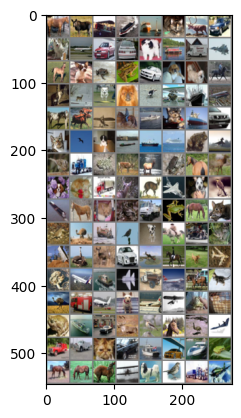

In [68]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [69]:
class ResNetWithLeakyReLU(nn.Module):
    def __init__(self, base_model='resnet18'):
        super().__init__()
        if base_model == 'resnet18':
            self.model = models.resnet18(weights=None)

        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)

        self._replace_relu_with_leaky_relu(self.model, negative_slope=0.01)

    def _replace_relu_with_leaky_relu(self, module, negative_slope=0.01):
        for name, child in module.named_children():
            if isinstance(child, nn.ReLU):
                setattr(module, name, nn.LeakyReLU(negative_slope=negative_slope, inplace=True))
            else:
                self._replace_relu_with_leaky_relu(child, negative_slope)
    
    def forward(self, x):
        return self.model(x)

net = ResNetWithLeakyReLU(base_model='resnet18')
net = net.to(device)  # Move model to GPU
print(f'Model moved to {device}')
print(f"Total params: {sum(p.numel() for p in net.parameters()):,}")

Model moved to cuda
Total params: 11,173,962


In [70]:
# Hyperparameters for this experiment
learning_rate = 0.01
momentum = 0.9
num_epochs = 100
weight_decay = 5e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Track experiment configuration
current_experiment = {
    'experiment_id': len(experiment_results) + 1,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_architecture': 'ResNet18 with LeakyReLU',
    'optimizer': 'SGD',
    'learning_rate': learning_rate,
    'momentum': momentum,
    'weight_decay': weight_decay,
    'batch_size': batch_size,
    'num_epochs': num_epochs,
    'device': str(device)
}

In [71]:
# Training loop with timing
print(f"Starting training on {device}...")
training_start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # Move data to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0
    
    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch + 1} completed in {epoch_time:.2f}s")

training_time = time.time() - training_start_time
print(f'Finished training in {training_time:.2f}s ({training_time/60:.2f} minutes)')

# Store training time in experiment
current_experiment['training_time_seconds'] = training_time

Starting training on cuda...
Epoch 1 completed in 6.20s
Epoch 2 completed in 5.27s
Epoch 3 completed in 6.01s
Epoch 4 completed in 6.32s
Epoch 5 completed in 6.06s
Epoch 6 completed in 6.26s
Epoch 7 completed in 4.76s
Epoch 8 completed in 5.88s
Epoch 9 completed in 5.99s
Epoch 10 completed in 6.14s
Epoch 11 completed in 6.49s
Epoch 12 completed in 5.73s
Epoch 13 completed in 6.82s
Epoch 14 completed in 6.47s
Epoch 15 completed in 6.30s
Epoch 16 completed in 6.39s
Epoch 17 completed in 5.21s
Epoch 18 completed in 6.22s
Epoch 19 completed in 6.33s
Epoch 20 completed in 6.10s
Epoch 21 completed in 6.40s
Epoch 22 completed in 4.91s
Epoch 23 completed in 5.89s
Epoch 24 completed in 6.12s
Epoch 25 completed in 6.31s
Epoch 26 completed in 6.22s
Epoch 27 completed in 5.91s
Epoch 28 completed in 5.21s
Epoch 29 completed in 6.18s
Epoch 30 completed in 6.15s
Epoch 31 completed in 6.05s
Epoch 32 completed in 6.15s
Epoch 33 completed in 4.96s
Epoch 34 completed in 6.14s
Epoch 35 completed in 6.43s


In [72]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Groundtruth:  cat   ship  ship  plane


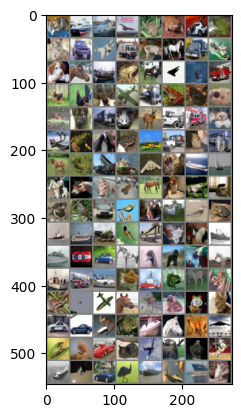

In [73]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('Groundtruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [75]:
# Load the same architecture used for training
net = ResNetWithLeakyReLU(base_model='resnet18')
net = net.to(device)  # Move to GPU
net.load_state_dict(torch.load(PATH, weights_only=True))
net.eval()  # Set to evaluation mode
print('Model loaded successfully!')

Model loaded successfully!


In [76]:
# Move images to GPU for inference
images = images.to(device)
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  car   plane


In [77]:
# Evaluate on full test set
print("Evaluating model on test set...")
eval_start_time = time.time()

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Move data to GPU
        images, labels = images.to(device), labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

eval_time = time.time() - eval_start_time
test_accuracy = 100 * correct / total

print(f'Accuracy of the network on the 10000 test images: {test_accuracy:.2f}%')
print(f'Evaluation completed in {eval_time:.2f}s')

# Store results in experiment tracker
current_experiment['test_accuracy'] = test_accuracy
current_experiment['eval_time_seconds'] = eval_time
current_experiment['correct_predictions'] = correct
current_experiment['total_test_samples'] = total

# Add to results list
experiment_results.append(current_experiment)
print(f"\nExperiment #{current_experiment['experiment_id']} saved!")

Evaluating model on test set...
Accuracy of the network on the 10000 test images: 86.34%
Evaluation completed in 0.99s

Experiment #1 saved!


## Save/Load Experiment Results
Save experiment tracking data to CSV for persistence across sessions

In [ ]:
# Save results to CSV
import os

csv_path = './experiment_results.csv'

# Convert current session results to DataFrame
if len(experiment_results) > 0:
    current_df = pd.DataFrame(experiment_results)
    
    # If file exists, load previous results and append
    if os.path.exists(csv_path):
        existing_df = pd.read_csv(csv_path)
        # Combine with current results, avoiding duplicates by timestamp
        all_results = pd.concat([existing_df, current_df]).drop_duplicates(subset=['timestamp'], keep='last')
        all_results.to_csv(csv_path, index=False)
        print(f"Updated {csv_path} with {len(current_df)} new experiment(s)")
    else:
        current_df.to_csv(csv_path, index=False)
        print(f"Created {csv_path} with {len(current_df)} experiment(s)")
    
    print(f"Total experiments saved: {len(pd.read_csv(csv_path))}")
else:
    print("No experiments to save. Run training and evaluation first!")

Updated ./experiment_results.csv with 1 new experiment(s)
Total experiments saved: 4


## View Experiment Results
Display all experiment runs in a table for comparison

In [80]:
# Display results as a DataFrame - including all saved experiments
import os

csv_path = './experiment_results.csv'

# Load all saved experiments from CSV if it exists
if os.path.exists(csv_path):
    all_experiments = pd.read_csv(csv_path)
    print(f"Loaded {len(all_experiments)} experiments from {csv_path}")
else:
    # Use current session results if no CSV exists
    all_experiments = pd.DataFrame(experiment_results)
    print("No saved experiments found. Showing current session only.")

# Reorder columns for better readability
column_order = [
    'experiment_id', 'timestamp', 'test_accuracy', 'model_architecture',
    'optimizer', 'learning_rate', 'momentum', 'weight_decay', 
    'batch_size', 'num_epochs', 'training_time_seconds', 'eval_time_seconds',
    'device', 'correct_predictions', 'total_test_samples'
]

# Only include columns that exist
column_order = [col for col in column_order if col in all_experiments.columns]
all_experiments = all_experiments[column_order]

# Sort by timestamp (most recent first)
if 'timestamp' in all_experiments.columns:
    all_experiments = all_experiments.sort_values('timestamp', ascending=False).reset_index(drop=True)

# Display the table
print("\n" + "=" * 150)
print("EXPERIMENT TRACKING TABLE - ALL RUNS")
print("=" * 150)

# Style the dataframe for better visualization
styled_df = all_experiments.style.background_gradient(
    subset=['test_accuracy'], 
    cmap='RdYlGn', 
    vmin=all_experiments['test_accuracy'].min() if len(all_experiments) > 0 else 0,
    vmax=all_experiments['test_accuracy'].max() if len(all_experiments) > 0 else 100
).format({
    'test_accuracy': '{:.2f}%',
    'training_time_seconds': '{:.2f}s',
    'eval_time_seconds': '{:.2f}s',
    'learning_rate': '{:.4f}',
    'momentum': '{:.2f}',
    'weight_decay': '{:.2e}'
})

display(styled_df)

# Show summary statistics
if len(all_experiments) > 0:
    print("\n" + "=" * 150)
    print("SUMMARY STATISTICS")
    print("=" * 150)
    print(f"Total Experiments: {len(all_experiments)}")
    print(f"Best Accuracy: {all_experiments['test_accuracy'].max():.2f}% (Experiment #{all_experiments.loc[all_experiments['test_accuracy'].idxmax(), 'experiment_id']:.0f})")
    print(f"Worst Accuracy: {all_experiments['test_accuracy'].min():.2f}%")
    print(f"Average Accuracy: {all_experiments['test_accuracy'].mean():.2f}%")
    print(f"Std Dev Accuracy: {all_experiments['test_accuracy'].std():.2f}%")
    print(f"Total Training Time: {all_experiments['training_time_seconds'].sum():.2f}s ({all_experiments['training_time_seconds'].sum()/60:.2f} min)")
    print(f"Average Training Time per Experiment: {all_experiments['training_time_seconds'].mean():.2f}s")
    
    # Show top 3 experiments
    print("\n" + "=" * 150)
    print("TOP 3 EXPERIMENTS BY ACCURACY")
    print("=" * 150)
    top_3 = all_experiments.nlargest(3, 'test_accuracy')[['experiment_id', 'timestamp', 'test_accuracy', 'model_architecture', 'learning_rate', 'batch_size', 'num_epochs']]
    display(top_3)
else:
    print("\nNo experiments to display yet. Run training first!")

Loaded 4 experiments from ./experiment_results.csv

EXPERIMENT TRACKING TABLE - ALL RUNS


,experiment_id,timestamp,test_accuracy,model_architecture,optimizer,learning_rate,momentum,weight_decay,batch_size,num_epochs,training_time_seconds,eval_time_seconds,device,correct_predictions,total_test_samples
0,1,2026-02-02 10:22:21,86.34%,ResNet18 with LeakyReLU,SGD,0.0100,0.90,5.00e-04,128,100,591.10s,0.99s,cuda,8634,10000
1,1,2026-02-02 09:59:39,67.35%,"Basic CNN (2 conv, 3 fc)",SGD,0.0010,0.90,0.00e+00,128,100,591.44s,0.91s,cuda,6735,10000
2,1,2026-02-02 09:29:38,65.74%,"Basic CNN (2 conv, 3 fc)",SGD,0.0010,0.90,0.00e+00,64,50,187.83s,0.82s,cuda,6574,10000
3,1,2026-02-02 09:21:38,51.88%,"Basic CNN (2 conv, 3 fc)",SGD,0.0010,0.90,0.00e+00,4,2,88.53s,4.94s,cuda,5188,10000



SUMMARY STATISTICS
Total Experiments: 4
Best Accuracy: 86.34% (Experiment #1)
Worst Accuracy: 51.88%
Average Accuracy: 67.83%
Std Dev Accuracy: 14.16%
Total Training Time: 1458.90s (24.31 min)
Average Training Time per Experiment: 364.72s

TOP 3 EXPERIMENTS BY ACCURACY


,experiment_id,timestamp,test_accuracy,model_architecture,learning_rate,batch_size,num_epochs
0,1,2026-02-02 10:22:21,86.34,ResNet18 with LeakyReLU,0.010,128,100
1,1,2026-02-02 09:59:39,67.35,"Basic CNN (2 conv, 3 fc)",0.001,128,100
2,1,2026-02-02 09:29:38,65.74,"Basic CNN (2 conv, 3 fc)",0.001,64,50


In [ ]:
# Optional: Load previous results from CSV
# Uncomment to load all previous experiments
# experiment_results = pd.read_csv('./experiment_results.csv').to_dict('records')
# print(f"Loaded {len(experiment_results)} previous experiments")